## Embeddings extraction
On this notebook I will compare a target image to a pool of other images, this simulates the process where a customer uploads his picture that will be compared to a store catalogue images.  

The strategy will be to use a neural network already trained on the imagenet dataset and use it to extract the embeddings of all the store images. These embeddings will be saved and when a new image is uploaded to the server the embedding of that image will be extracted and compared to the other ones where the "n" most similar images will be returned. To compare the images cosine similarity will be used.

For efficiency purposes embeddings are run only once and exported to a csv file, then the file is loaded into memory.

In [2]:
%matplotlib inline
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.applications.inception_v3 import InceptionV3 , preprocess_input
from keras.preprocessing import image
import cv2
from scipy.spatial.distance import cdist
# pip install h5py==2.8.0rc1 to disable the h5py warning

### Loading <<\category\\>> images

In [3]:
def show_image(img_path, bbox=False):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.imshow(mpimg.imread(img_path))
    ax.axis("off")
    
    if bbox == True: #xy = (left, top) 
        img_id = img_path.split("/")[-1].split(".")[0]
        img_data = customer_df[customer_df["photo"] == int(img_id)]
        
        if img_data["category"].unique().shape[0] > 1: #exception image with multiple categories
            print("Categories: ", img_data["category"].value_counts().index.tolist())
            img_category = input("Please specify category: ")
            img_data = img_data[img_data["category"] == img_category]
            
        if img_data.shape[0] > 1: #exception image with multiple bboxes, plots all
            for index, row in img_data.iterrows():
                top = int(row["top"])
                left = int(row["left"])
                width = int(row["width"])
                height = int(row["height"])

                rect = patches.Rectangle(xy=(left,top),width=width,height=height,linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
            plt.show()
            
        else:
            top = int(img_data["top"])
            left = int(img_data["left"])
            width = int(img_data["width"])
            height = int(img_data["height"])

            rect = patches.Rectangle(xy=(left,top),width=width,height=height,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
            plt.show()

In [34]:
customer_df = pd.read_csv("./customer_df.csv")
retrieval_df = pd.read_csv("./retrieval_df.csv")

customer_df = customer_df[customer_df["category"] == "belts"]
retrieval_df = retrieval_df[retrieval_df["category"] == "belts"]

To evaluate the model we will use only the images from customers that can be matched to a retrieved photo

In [36]:
matched_df = pd.merge(customer_df, retrieval_df, 
                      left_on=['product', 'category', 'id'], 
                      right_on=['product', 'category', 'id'], 
                      copy=False)
matched_df.shape

(578, 9)

In [212]:
matched_df.head()

,photo_x,product,category,id,height,left,top,width,photo_y
0,10104,789,belts,789_belts,16,112,142,60,77676
1,10104,789,belts,789_belts,16,112,142,60,77677
2,10104,789,belts,789_belts,16,112,142,60,77678
3,10104,789,belts,789_belts,16,112,142,60,77679
4,10222,789,belts,789_belts,6,122,142,50,77676


### Warning: To investigate
Some photos may appear in both customer and retrieval folders with different photo id. List below:

10104, 10222 - customer belt<br>
77679, 77678 - retrieval belt

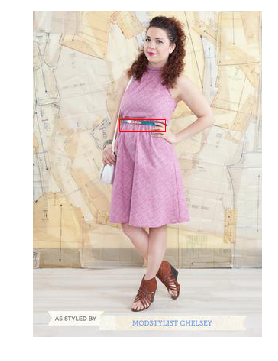

In [42]:
show_image("../utils/photos_dresses/customer/10104.jpg", bbox=True)

In [236]:
def crop_image(image_customer, show=False):
    img_array = mpimg.imread(image_customer)
    photo_name = image_customer.split("/")[-1].split(".")[0]
    image_customer = customer_df[customer_df["photo"] == int(photo_name)]
    if len(image_customer) > 1:
        image_customer["fix_bbox"] = image_customer["height"] + image_customer["width"] #aggs height and width, sorts them and picks the largest box
        image_customer = image_customer.sort_values(by="fix_bbox", ascending=False)[0:1] #this fixes a bug with some bboxes being 1px long
    
    x0 = int(image_customer["left"].values)
    y0 = int(image_customer["top"].values)
    width = int(image_customer["width"].values)
    height = int(image_customer["height"].values)
    image_cropped = img_array[y0:y0+height , x0:x0+width, :]
    
    if show == True:
        plt.imshow(image_cropped)
        plt.axis("off")
        plt.show()
    
    image_cropped = cv2.resize(image_cropped, dsize=(125, 125), interpolation=cv2.INTER_CUBIC)
    return image_cropped

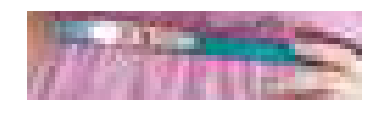

In [44]:
image_cropped = crop_image("../utils/photos_belts/customer/10104.jpg", show=True)

In [45]:
model = InceptionV3(weights="imagenet", include_top=False)

In [229]:
# Returns the array representation of all images in the path specified in raw format for display and processed format for the NN
def preprocess_img(dataset_path):
    img_paths = os.listdir(dataset_path)
    img_paths = [os.path.join(dataset_path, img) for img in img_paths]
    raw_imgs = [image.load_img(img, target_size=(250,250)) for img in img_paths]
    proc_imgs = np.array([preprocess_input(np.expand_dims(image.img_to_array(img), axis=0)[0]) for img in raw_imgs])
    return raw_imgs, proc_imgs

#calculates the embeddings, write=True to get all the photos' embeddings to a csv, write=False for one-off customer queries
def embeddings(img_arrays):
    embeddings_img = [model.predict(np.expand_dims(img, axis=0)).flatten() for img in tqdm(img_arrays)]
    embeddings_img = np.array(embeddings_img, np.float16) #float16 reduces decimal precision but saves disk space
    
    print("Writing to file")
    np.save("embeddings_belts.npy", embeddings_img) #npy files save/load faster than csv when working with ndarrays

def recommend_user(target_img, embs_catalogue, bbox=True, method="cosine"):
    if bbox == True:
        raw_img = crop_image(target_img) #crops to bbox and resizes
    else:
        raw_img = plt.imread(target_img) #allows testing with an image without bboxes
        raw_img = cv2.resize(raw_img, dsize=(250, 250), interpolation=cv2.INTER_CUBIC)

    proc_img = preprocess_input(np.expand_dims(raw_img, axis=0)) #preprocess to NN format
    embs_target = model.predict(proc_img).flatten() #extracts embedding
    
    distance = cdist(embs_catalogue, embs_target.reshape(1,-1), method) #run distances from user photo to catalogue
    rank = np.argsort(distance.ravel()) #ranks by similarity, returns the indices that would sort the distance array
    return rank

def show_recommend(ids, imgs_arrays, target_img, bbox=True):  
    fig = plt.figure()
    gs = gridspec.GridSpec(1, 2)
    
    #show target image
    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(mpimg.imread(target_img))
    plt.title("User image")
    plt.axis("off")
    
    if bbox == True:  
        #show target image cropped
        img_array = mpimg.imread(target_img)
        photo_name = target_img.split("/")[-1].split(".")[0]
        image_customer = customer_df[customer_df["photo"] == int(photo_name)]
        if len(image_customer) > 1:
            image_customer["fix_bbox"] = image_customer["height"] + image_customer["width"]
            image_customer = image_customer.sort_values(by="fix_bbox", ascending=False)[0:1]
        x0 = int(image_customer["left"].values)
        y0 = int(image_customer["top"].values)
        width = int(image_customer["width"].values)
        height = int(image_customer["height"].values)
        image_cropped = img_array[y0:y0+height , x0:x0+width, :]
        ax = fig.add_subplot(gs[0, 1])
        ax.imshow(image_cropped)
        plt.title("Cropped image")
        plt.axis("off")
        plt.show()

    print("Top {} similar images".format(len(ids)))
    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(1, len(ids))
    for i in range(len(ids)):
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(imgs_arrays[ids[i]])
        ax.axis("off")
    plt.show()

In [230]:
%%time
#Needed to calculate embeddings from catalogue / Needed to display images on the end of the notebook
catalogue_path = "../utils/photos_belts/retrieval"
img_all_raw, img_all = preprocess_img(catalogue_path)

Wall time: 1.89 s


In [231]:
%%time
embeddings(img_all) #ONLY RUN THE FIRST TIME TO SAVE ALL EMBEDDINGS TO DISK

100%|██████████████████████████████████████████████████████████████████████████████| 1145/1145 [00:30<00:00, 37.76it/s]


Writing to file
Wall time: 30.9 s


In [232]:
%%time 
#using np to load all embeddings, watch out, this will initially fill up all ram
embs_catalogue = np.load("./embeddings_belts.npy")

Wall time: 29.9 ms


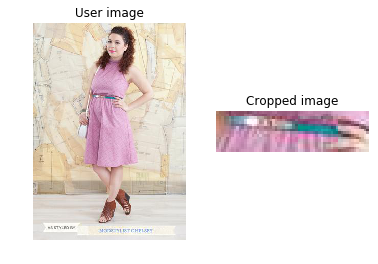

Top 10 similar images


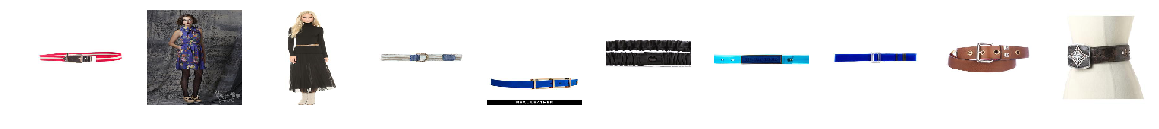

Wall time: 550 ms


In [237]:
%%time
target_img = "../utils/photos_belts/customer/10104.jpg"
rank = recommend_user(target_img, embs_catalogue)
n = 10
show_recommend(rank[0:n], img_all_raw, target_img)

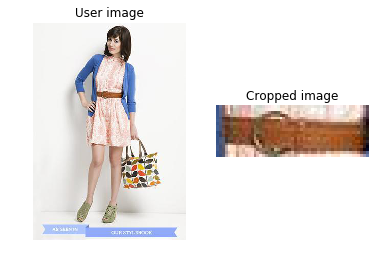

Top 10 similar images


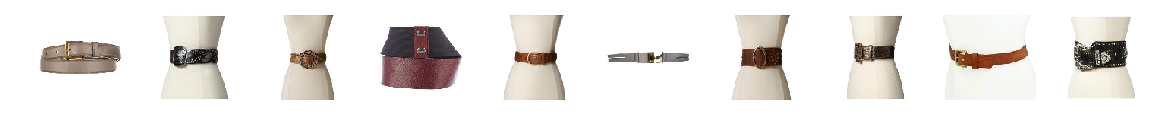

Wall time: 529 ms


In [238]:
%%time
target_img = "../utils/photos_belts/customer/5976.jpg"
rank = recommend_user(target_img, embs_catalogue)
n = 10
show_recommend(rank[0:n], img_all_raw, target_img)

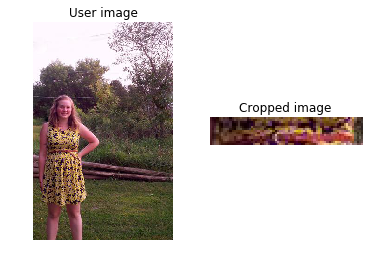

Top 10 similar images


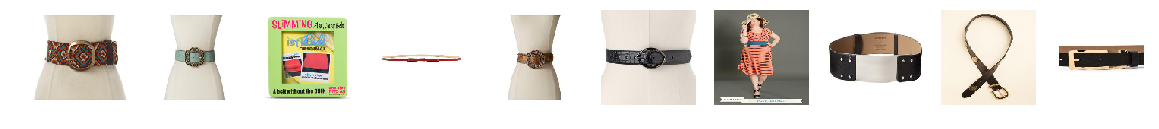

Wall time: 764 ms


In [239]:
%%time
target_img = "../utils/photos_belts/customer/5851.jpg"
rank = recommend_user(target_img, embs_catalogue)
n = 10
show_recommend(rank[0:n], img_all_raw, target_img)

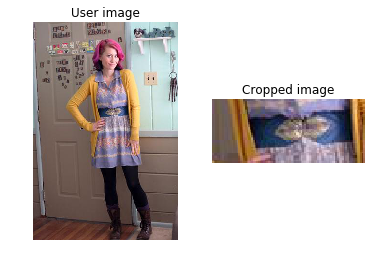

Top 10 similar images


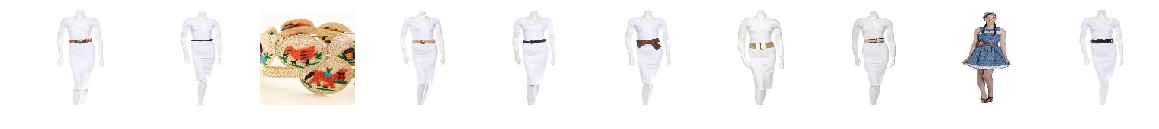

Wall time: 547 ms


In [246]:
%%time
target_img = "../utils/photos_belts/customer/4267.jpg"
rank = recommend_user(target_img, embs_catalogue)
n = 10
show_recommend(rank[0:n], img_all_raw, target_img)

Below we can see that if we try with a perfect image it works pretty well

Top 5 similar images


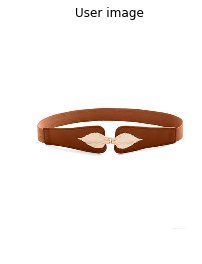

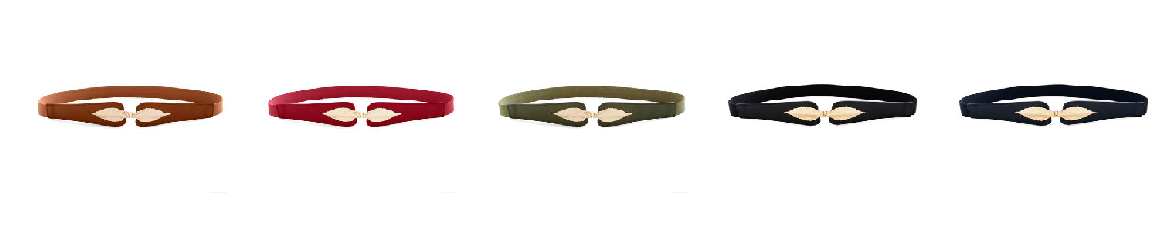

Wall time: 547 ms


In [211]:
%%time
target_img = "../utils/photos_belts/retrieval/33221.jpg"
rank = recommend_user(target_img, embs_catalogue, bbox=False)
n = 5
show_recommend(rank[0:n], img_all_raw, target_img, bbox=False)